In [1]:
import os
import sys
BASE_DIR = r"C:\Users\nino.zhou\Desktop\my_project\cp_newbank_mobile_behavior"
sys.path.insert(0, BASE_DIR)

import json
import pandas as pd
import numpy as np
from config import setting
from config import setting
import tensorflow as tf
import pandas as pd
import copy
from xgboost import XGBClassifier
import itertools
from sklearn.externals import joblib
import datetime

C:\Users\nino.zhou\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
df_train = pd.read_csv(setting.BASE_DIR + "\data_model\data\sensor_train.csv")
df_train

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id
0,0,27,0.3,-0.3,0.1,0.6,4.5,8.8,0
1,0,108,0.1,-0.0,-0.4,0.4,4.7,8.4,0
2,0,198,0.1,0.0,0.3,0.9,4.6,9.0,0
3,0,297,0.1,-0.1,-0.5,0.8,4.7,7.2,0
4,0,388,0.1,0.2,0.6,0.9,4.7,8.9,0
...,...,...,...,...,...,...,...,...,...
425354,7291,4561,-0.1,-0.5,-1.7,-0.2,3.4,7.4,18
425355,7291,4647,0.7,-1.9,1.1,0.5,1.7,10.7,18
425356,7291,4735,1.3,-1.4,-0.5,1.4,2.1,8.0,18
425357,7291,4830,1.2,-1.6,-0.1,1.6,1.8,9.2,18


## 1. 构造特征

In [3]:
# 标准化
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
col_list =[col for col in df_train.columns if col not in ["fragment_id", "behavior_id"]]
scaler = standard_scaler.fit(df_train.loc[:, col_list])
df_train.loc[:, col_list] = standard_scaler.transform(df_train.loc[:, col_list])
df_train

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id
0,0,-1.715275,0.468872,-0.440625,0.105232,-0.110955,0.594269,0.367448,0
1,0,-1.659115,0.145918,0.117397,-0.592110,-0.171644,0.661425,0.216690,0
2,0,-1.596715,0.145918,0.117397,0.384168,-0.019923,0.627847,0.442827,0
3,0,-1.528075,0.145918,-0.068610,-0.731578,-0.050267,0.661425,-0.235584,0
4,0,-1.464982,0.145918,0.489412,0.802573,-0.019923,0.661425,0.405138,0
...,...,...,...,...,...,...,...,...,...
425354,7291,1.428301,-0.177036,-0.812640,-2.405198,-0.353708,0.224910,-0.160205,18
425355,7291,1.487928,1.114779,-3.416744,1.499915,-0.141299,-0.345918,1.083549,18
425356,7291,1.548941,2.083640,-2.486707,-0.731578,0.131798,-0.211606,0.065932,18
425357,7291,1.614808,1.922163,-2.858721,-0.173705,0.192486,-0.312340,0.518206,18


In [4]:
data_list = []
max_seq_len = 61
embedding_size = 7

def create_feature_func(df_groupby):
    y_true = df_groupby["behavior_id"].iloc[0]
    fragment_id = df_groupby["fragment_id"].iloc[0]
    df_groupby = df_groupby.drop(["behavior_id", "fragment_id"], axis=1)
    
    # 不足最大序列长度的用0填充
    if df_groupby.shape[0] < max_seq_len:
        pad_num = max_seq_len - df_groupby.shape[0]
        df_padding = df_train[: pad_num].drop(["behavior_id", "fragment_id"], axis=1).copy()
        df_padding[:] = 0
        df_groupby = df_groupby.append(df_padding, ignore_index=True)
    
    X_feature = list(df_groupby.values.reshape(-1,))
    data_list.append(X_feature + [y_true, fragment_id])

df_train.groupby("fragment_id").apply(create_feature_func)
df_feature = pd.DataFrame(data_list)
df_feature

,0,1,2,3,4,5,6,7,8,9,...,419,420,421,422,423,424,425,426,427,428
0,-1.715275,0.468872,-0.440625,0.105232,-0.110955,0.594269,0.367448,-1.659115,0.145918,0.117397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,-1.693782,-0.177036,0.117397,0.384168,-0.050267,0.795738,0.405138,-1.632768,0.145918,0.117397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,-1.722208,-0.015559,0.117397,-0.173705,-0.050267,0.728581,0.329759,-1.662582,0.145918,0.117397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2
3,-1.675062,0.145918,0.117397,-0.173705,-0.050267,0.695003,0.141311,-1.617515,-0.177036,0.303405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
4,-1.679915,-0.015559,0.117397,-0.313173,-0.050267,0.695003,0.103622,-1.616822,-0.338513,0.117397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7287,-1.732608,9.188620,4.767582,-1.847325,3.075181,-2.864277,-3.439193,-1.672982,1.760686,-5.834840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,7287
7288,-1.702795,-0.984420,1.977471,-1.428920,1.406253,-3.132902,-2.572334,-1.644555,2.729547,3.279523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,7288
7289,-1.709728,3.859885,1.419449,-4.078818,1.618662,-3.670152,-3.665330,-1.648715,2.891024,-5.462825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,7289
7290,-1.701408,4.182838,3.465531,-2.963072,1.982791,-3.099324,-3.816088,-1.642475,0.145918,-0.068610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,7290


In [5]:
def ramdom_df(df):
    """随机打乱df数据的顺序"""
    random_list = list(df.index)
    np.random.shuffle(random_list)
    return df.loc[random_list]
df_feature = ramdom_df(df_feature)
df_feature.shape

(7292, 429)

In [6]:
# 构造特征和标签列
arr_feature = df_feature.iloc[:, :-2].values.reshape(df_feature.shape[0], max_seq_len, embedding_size)
arr_y_true = df_feature.iloc[:, -2].values
arr_fragment_ids = df_feature.iloc[:, -1].values  # 保存每个样本原始的fragment_id，因为后面要根据这个保存数据预测结果

arr_feature = arr_feature.reshape(-1, 61, 7)
arr_feature.shape, arr_y_true.shape

((7292, 61, 7), (7292,))

In [7]:
# 保存训练测试集，因为bilstm+resnet模型也使用同样的训练测试集
np.save(setting.BASE_DIR + "/data_model/data/lstm_arr_x", arr_feature)
np.save(setting.BASE_DIR + "/data_model/data/lstm_arr_y", arr_y_true)
np.save(setting.BASE_DIR + "/data_model/data/lstm_arr_fragment_ids", arr_fragment_ids)

In [8]:
# 切分训练测试集，并转张量，目标列one-hot
tf_x = tf.constant(arr_feature)
tf_y_true = tf.constant(arr_y_true)
y_train, y_test = tf_y_true[:5000], tf_y_true[5000:]
tf_y_true = tf.one_hot(tf_y_true, depth=19)
X_train, X_test, y_train_one_hot, y_test_one_hot = tf_x[:5000], tf_x[5000:], tf_y_true[:5000], tf_y_true[5000:]
X_train.shape, X_test.shape, y_train_one_hot.shape, y_test_one_hot.shape

(TensorShape([Dimension(5000), Dimension(61), Dimension(7)]),
 TensorShape([Dimension(2292), Dimension(61), Dimension(7)]),
 TensorShape([Dimension(5000), Dimension(19)]),
 TensorShape([Dimension(2292), Dimension(19)]))

## 2. 模型构造与训练评估

In [9]:
from model_lstm.modeling import LstmModel
model = LstmModel().initialize_lstm_model()

1 Physical GPUs, 1 Logical GPUs
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-07-04 18:29:01,640 default INFO 已成功初始化模型


In [10]:
def feature_generater(tf_x, tf_y_one_hot, batch_size, method="train"):
    j = 0
    while True:
        tf_x_batch = tf_x[j: j + batch_size]
        tf_y_one_hot_batch = tf_y_one_hot[j: j + batch_size]

        if tf_x_batch.shape[0] == 0:
            break

        j += batch_size

        if method == "train":
            yield tf_x_batch, tf_y_one_hot_batch
        else:
            yield tf_x_batch

In [11]:
with tf.Session() as sess:
    y_test = y_test.eval()
y_test

array([ 6,  6, 16, ..., 17,  1, 17], dtype=int64)

In [12]:
import math
accuracy_list = []
for i in range(1, 60):
    history = model.fit(feature_generater(X_train, y_train_one_hot, batch_size=128), epochs=1, steps_per_epoch=math.ceil(int(X_train.shape[0])/128))
    y_prob = model.predict(feature_generater(X_test, y_test_one_hot, batch_size=128, method="test"), steps=math.ceil(int(X_test.shape[0])/128))
    y_pred = np.argmax(y_prob, axis=1)
    # 计算准确率
    accuracy = np.mean(np.equal(y_test, y_pred))
    accuracy_list.append([i*10, history.history["acc"][-1], accuracy])
    print("第{}epoch训练，训练集准确率{}，测试集准确率{}".format(i * 10, history.history["acc"][-1], accuracy))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
40/40 [==============================] - 157s 4s/step - loss: 0.0474 - acc: 0.2006
第10epoch训练，训练集准确率0.20059999823570251，测试集准确率0.174956369982548
40/40 [==============================] - 161s 4s/step - loss: 0.0446 - acc: 0.2792
第20epoch训练，训练集准确率0.2791999876499176，测试集准确率0.23342059336823734
40/40 [==============================] - 161s 4s/step - loss: 0.0429 - acc: 0.3192
第30epoch训练，训练集准确率0.3192000091075897，测试集准确率0.3089005235602094
40/40 [==============================] - 176s 4s/step - loss: 0.0415 - acc: 0.3504
第40epoch训练，训练集准确率0.35040000081062317，测试集准确率0.3276614310645724
40/40 [==============================] - 164s 4s/step - loss: 0.0401 - acc: 0.3760
第50epoch训练，训练集准确率0.37599998712539673，测试集准确率0.3368237347294939
40/40 [==============================] - 166s 4s/step - loss: 0.0391 - acc: 0.3932
第60epoch训练，训练集准确率0.39320001006126404，测试集准确率0.35602094240837695
40/40 [==============================

40/40 [==============================] - 207s 5s/step - loss: 0.0120 - acc: 0.8498
第550epoch训练，训练集准确率0.8497999906539917，测试集准确率0.5488656195462478
40/40 [==============================] - 207s 5s/step - loss: 0.0120 - acc: 0.8432
第560epoch训练，训练集准确率0.8432000279426575，测试集准确率0.5929319371727748
40/40 [==============================] - 208s 5s/step - loss: 0.0111 - acc: 0.8570
第570epoch训练，训练集准确率0.8569999933242798，测试集准确率0.5641361256544503
40/40 [==============================] - 209s 5s/step - loss: 0.0107 - acc: 0.8634
第580epoch训练，训练集准确率0.8633999824523926，测试集准确率0.5802792321116929
40/40 [==============================] - 212s 5s/step - loss: 0.0106 - acc: 0.8678
第590epoch训练，训练集准确率0.8677999973297119，测试集准确率0.5667539267015707


In [13]:
epoch_list = [record_list[0] for record_list in accuracy_list]
train_acc_list = [record_list[1] for record_list in accuracy_list]
test_acc_list = [record_list[2] for record_list in accuracy_list]

In [14]:
from mpl_toolkits import mplot3d  # matplotlib绘制三维图，必须导入此包
# 在jupyter使用matplotlib绘图加的前缀，放置未知问题
%matplotlib inline  
import pandas as pd  # 导入pandas
import numpy as np  # 导入numpy
import tensorflow as tf  # 导入tensorflow
import matplotlib.pyplot as plt  # 导入matplotlib
plt.rcParams['font.sans-serif'] = 'fangsong'  # 解决matplotlib中文显示
plt.rcParams['axes.unicode_minus'] = False  # 解决matplotlib坐标轴负号显示

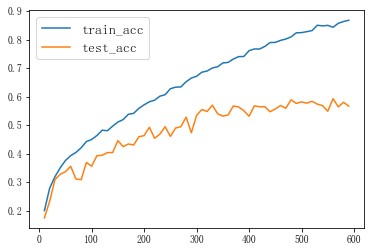

In [16]:
plt.plot(epoch_list, train_acc_list, label="train_acc")
plt.plot(epoch_list, test_acc_list, label="test_acc")
plt.legend(fontsize=14)

### 保存模型与预测结果

In [17]:
file_num = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
model.save(os.path.join(setting.BASE_DIR, "./data_model/model/lstm_model/{}_lstm_model.h5".format(file_num)))

In [19]:
y_prob = model.predict(feature_generater(X_test, y_test_one_hot, batch_size=128, method="test"), steps=math.ceil(int(X_test.shape[0])/128))
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([ 6,  6, 16, ...,  5,  1, 17], dtype=int64)

In [24]:
arr_test_fragment_id = arr_fragment_ids[5000:]
arr_test_fragment_id

array([2991, 2650, 6537, ..., 6889,  356, 6741], dtype=int64)

In [31]:
df_train["category_lstm"] = None
for fragment_id, category in zip(arr_test_fragment_id, y_pred):
    index = df_train[df_train["fragment_id"] == fragment_id].index
    df_train.loc[index, "category_lstm"] = category
df_train

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id,lstm_category,category_lstm
0,0,-1.715275,0.468872,-0.440625,0.105232,-0.110955,0.594269,0.367448,0,None,None
1,0,-1.659115,0.145918,0.117397,-0.592110,-0.171644,0.661425,0.216690,0,None,None
2,0,-1.596715,0.145918,0.117397,0.384168,-0.019923,0.627847,0.442827,0,None,None
3,0,-1.528075,0.145918,-0.068610,-0.731578,-0.050267,0.661425,-0.235584,0,None,None
4,0,-1.464982,0.145918,0.489412,0.802573,-0.019923,0.661425,0.405138,0,None,None
...,...,...,...,...,...,...,...,...,...,...,...
425354,7291,1.428301,-0.177036,-0.812640,-2.405198,-0.353708,0.224910,-0.160205,18,None,None
425355,7291,1.487928,1.114779,-3.416744,1.499915,-0.141299,-0.345918,1.083549,18,None,None
425356,7291,1.548941,2.083640,-2.486707,-0.731578,0.131798,-0.211606,0.065932,18,None,None
425357,7291,1.614808,1.922163,-2.858721,-0.173705,0.192486,-0.312340,0.518206,18,None,None


In [33]:
# 构造行号（因为元数据就是按顺序排列，因此不需重置顺序）
df_train = df_train.reset_index()
df_train = df_train.rename(columns={"index": "id"})

df_train = df_train[["id", "fragment_id", "time_point", "behavior_id", "category_lstm"]]
df_train.to_csv(setting.BASE_DIR + "\data_model\data\category_lstm.csv")
df_train

,id,fragment_id,time_point,behavior_id,category_lstm
0,0,0,-1.715275,0,None
1,1,0,-1.659115,0,None
2,2,0,-1.596715,0,None
3,3,0,-1.528075,0,None
4,4,0,-1.464982,0,None
...,...,...,...,...,...
425354,425354,7291,1.428301,18,None
425355,425355,7291,1.487928,18,None
425356,425356,7291,1.548941,18,None
425357,425357,7291,1.614808,18,None
